# This notebook plots errors in MOSAIKS predictions against errors in CNN predictions

In [1]:
from mosaiks import config as c
import os
import pickle
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr

from mosaiks.utils.imports import *

%matplotlib inline

In [2]:
# plot settings
plt.rcParams["pdf.fonttype"] = 42
sns.set(context="paper", style="ticks")

## Get task names in the specified order

In [3]:
# get task names
c_by_app = [getattr(c, i) for i in c.app_order]
num_tasks = len(c.app_order)
disp_names = [config["disp_name"] for config in c_by_app]

## Grab primary MOSAIKS analysis predictions and labels

In [4]:
# get variables and determine if sampled UAR or POP in main analysis
variables = [config["variable"] for config in c_by_app]
sample_types = [config["sampling"] for config in c_by_app]

In [5]:
# get filepaths for data
file_paths_local = []
filetype = ["testset", "scatter"]

for tx, t in enumerate(c.app_order):
    c = io.get_filepaths(c, t)

    for ft in filetype:
        this_filename = f"outcomes_{ft}_obsAndPred_{t}_{variables[tx]}_CONTUS_16_640_{sample_types[tx]}_100000_0_random_features_3_0.data"
        this_filepath_local = os.path.join(c.fig_dir_prim, this_filename)
        file_paths_local.append(this_filepath_local)

In [6]:
mos_dfs = []

for tx, t in enumerate(c.app_order):
    file1 = file_paths_local[tx * 2]
    file2 = file_paths_local[tx * 2 + 1]
    dfs_task = []

    # grab the test set and validation/training set; concatenate to match test set for CNN

    for fidx in [0, 1]:

        with open(file_paths_local[tx * 2 + fidx], "rb") as file_this:
            data_this = pickle.load(file_this)

        mos_dfs.append(
            pd.DataFrame(
                {
                    "truth": np.squeeze(data_this["truth"]),
                    "preds": data_this["preds"],
                    "lat": data_this["lat"],
                    "lon": data_this["lon"],
                },
                index=[t] * len(data_this["lat"]),
            )
        )

mos_df = pd.concat(mos_dfs)
mos_df.index.name = "task"
mos_df["errors"] = mos_df["truth"] - mos_df["preds"]

## Grab CNN predictions

In [7]:
file_paths_local = [
    os.path.join(c.data_dir, "output", "cnn_comparison", f"resnet18_{t}.pickle")
    for t in c.app_order
]
cnn_dfs = []

for tx, t in enumerate(c.app_order):

    with open(file_paths_local[tx], "rb") as file_this:
        data_this = pickle.load(file_this)

    cnn_dfs.append(
        pd.DataFrame(
            {
                "truth": np.squeeze(data_this["y_test"]),
                "preds": np.squeeze(data_this["y_test_pred"]),
                "test_r2": data_this["test_r2"],
            },
            index=pd.MultiIndex.from_product(
                [[t], np.squeeze(data_this["ids_test"])], names=["task", "ID"]
            ),
        )
    )

cnn_df = pd.concat(cnn_dfs)
cnn_df["errors"] = cnn_df.truth - cnn_df.preds

## Merge CNN errors to MOSAIKS errors

In [8]:
latlons = {}
for s in ["UAR", "POP"]:
    _, latlons[s] = io.get_X_latlon(c, s)
latlons = pd.concat(latlons.values())
latlons = latlons.drop_duplicates()

In [9]:
cnn_df = (
    cnn_df.join(latlons, on="ID", how="left")
    .reset_index()
    .set_index(["task", "lat", "lon"])
)
mos_df = mos_df.set_index(["lat", "lon"], append=True)
merged_df = mos_df.join(cnn_df, lsuffix="_mos", rsuffix="_cnn")
# keep only matched labels
merged_df = merged_df[merged_df.truth_cnn.notnull()]

## Compute R2s between CNN and MOSAIKS predictions and errors

In [10]:
r2s = []
for t in c.app_order:
    r2s.append(
        pd.DataFrame(
            {
                "R2preds": pearsonr(
                    merged_df.loc[t]["preds_cnn"], merged_df.loc[t]["preds_mos"]
                )[0]
                ** 2,
                "R2errors": pearsonr(
                    merged_df.loc[t]["errors_cnn"], merged_df.loc[t]["errors_mos"]
                )[0]
                ** 2,
            },
            index=[t],
        )
    )
r2s_df = pd.concat(r2s)

## Plot CNN vs MOSAIKS predictions and errors

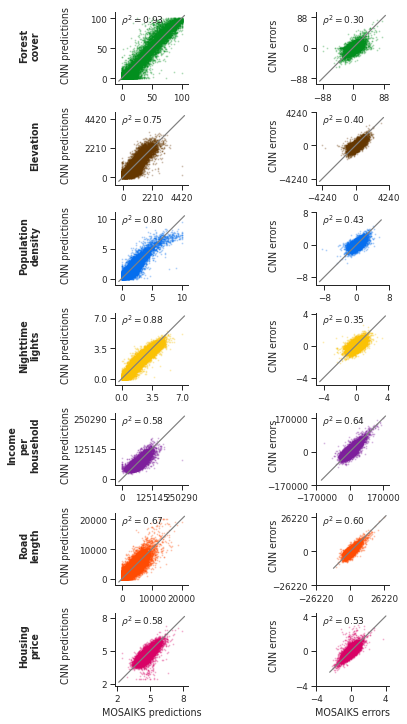

In [25]:
# settings for text formatting
yloc = np.linspace(1, 1 / 6, 7) - 0.06

fig, ax = plt.subplots(7, 2, figsize=(6, 10))

for tx, t in enumerate(c.app_order):

    # simplify ticks
    maxerr = round(merged_df.loc[t].filter(like="errors").abs().max().max())
    maxpred = round(merged_df.loc[t].filter(like="preds").abs().max().max())
    minpred = round(merged_df.loc[t].filter(like="preds").abs().min().min())

    if t in ["elevation", "income", "roads"]:
        maxerr = round(maxerr / 10) * 10
        maxpred = round(maxpred / 10) * 10
        minpred = round(minpred / 10) * 10

    errticks = np.linspace(-1 * maxerr, maxerr, 3)
    predticks = np.linspace(minpred, maxpred, 3)

    for jx, j in enumerate([("preds", predticks), ("errors", errticks)]):
        kind = j[0]
        ticks = j[1]
        ax[tx, jx].plot(
            merged_df.loc[t][f"{kind}_mos"],
            merged_df.loc[t][f"{kind}_cnn"],
            "o",
            color=c_by_app[tx]["color"],
            alpha=0.2,
            markersize=1,
        )
        x = np.linspace(*ax[tx, jx].get_xlim())
        ax[tx, jx].plot(x, x, color="grey")

        # force tick marks to be the same
        ax[tx, jx].set_xticks(ticks)
        ax[tx, jx].set_yticks(ticks)
        # force equality of lines
        ax[tx, jx].set_aspect("equal")
        # kill left and top lines
        sns.despine(ax=ax[tx, jx])
        # add R2
        r2 = r2s_df.loc[t].filter(like=kind)[0].round(2)
        txt = fr"$\rho^2 = {r2:.2f}$"
        ax[tx, jx].annotate(
            txt, xy=(6, 72), xycoords="axes points", size=9, ha="left", va="top"
        )

    # add evenly spaced y labels
    fig.text(
        0.55,
        yloc[tx],
        "CNN errors",
        rotation="vertical",
        rotation_mode="anchor",
        va="center",
        ha="center",
    )

    fig.text(
        0.07,
        yloc[tx],
        "CNN predictions",
        rotation="vertical",
        rotation_mode="anchor",
        va="center",
        ha="center",
    )

    fig.text(
        0.01,
        yloc[tx],
        c_by_app[tx]["disp_name"].capitalize().replace(" ", "\n"),
        weight="bold",
        rotation="vertical",
        rotation_mode="anchor",
        va="bottom",
        ha="center",
    )


ax[6, 0].set_xlabel("MOSAIKS predictions", ha="center", va="top", rotation="horizontal")
ax[6, 1].set_xlabel("MOSAIKS errors", ha="center", va="top", rotation="horizontal")

fig.tight_layout(pad=0.5)

In [26]:
# Save
save_dir = os.path.join(c.res_dir, "figures", "FigS17")
os.makedirs(save_dir, exist_ok=True)
fig.savefig(
    os.path.join(save_dir, "cnn_mosaiks_predictions_errors_scatter.png"),
    dpi=300,
    tight_layout=True,
    bbox_inches="tight",
)